<h1 style="text-align:center;">Practical session 12</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [99]:
# Generals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Feature extraction
from sklearn.feature_selection import VarianceThreshold

from boruta import BorutaPy
from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import optuna

# Data

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C92,C93,C94,C95,C96,C97,C98,C99,C100,tumor_type
0,174.0,650.0,2.588828e+09,4.300822,324.0,2.196185,1085.0,357.892864,169.490477,256.0,...,39.115214,35.693137,39.874804,15651.083333,29.130457,0.795019,3806.004555,0.243178,15709.0,HGG
1,427.0,826.0,1.555094e+09,4.670797,229.5,2.685919,1077.0,626.103994,128.342289,632.0,...,23.769729,24.413111,27.000000,3703.416667,18.059959,0.727742,1590.651380,0.429509,3731.0,HGG
2,212.0,697.0,6.472778e+09,4.796344,283.0,2.510939,1170.0,459.821288,154.048324,457.0,...,46.238512,44.944410,46.914816,26368.250000,37.044511,0.752399,5694.078769,0.215945,26400.0,HGG
3,429.9,856.0,6.238777e+09,4.777974,210.0,4.546907,1463.0,633.593407,134.813886,612.0,...,36.055513,54.626001,64.327288,14306.666667,26.111726,0.597259,4771.779131,0.333535,14410.0,HGG
4,358.0,649.0,1.212578e+10,4.199889,143.0,3.011379,1056.0,508.111091,88.454307,511.0,...,57.706152,59.774577,60.646517,44537.541667,43.406304,0.634706,9573.316675,0.214949,44774.0,HGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,3754.0,7206.9,1.021032e+12,7.652972,1937.0,2.885087,11777.0,5592.867096,1065.960253,5670.0,...,49.040799,41.146081,53.972215,30850.416667,32.945548,0.717464,6630.174444,0.214914,30932.0,HGG
355,648.0,1422.0,2.668548e+10,5.384028,463.0,3.096456,2749.0,993.503008,246.611399,972.0,...,66.910388,67.268120,69.778220,24684.666667,31.414140,0.597705,6859.333413,0.277878,24765.0,HGG
356,2250.2,5166.0,2.305284e+11,7.453490,1575.5,2.531188,7216.0,3680.912932,891.534753,3644.0,...,46.957428,41.303753,47.686476,15592.375000,26.732679,0.693717,4350.875982,0.279039,15643.0,HGG
357,1652.0,5113.0,6.660589e+11,7.591514,2107.0,2.602830,8575.0,3346.971976,1086.213192,3359.0,...,54.083269,51.039201,56.142675,51393.333333,41.408206,0.820776,8144.490174,0.158474,51455.0,HGG


# Feature extraction

## Reproducibility analysis

In [6]:
def apply_variance_threshold(df, target_col, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    df_features = selector.fit_transform(df.drop(columns=[target_col]))
    selected_columns = df.drop(columns=[target_col]).columns[selector.get_support()]
    
    return df_features, selected_columns

In [7]:
df_features, selected_columns_after_variance = apply_variance_threshold(df, "tumor_type")

## Calculation of the "importance of variables".

In [45]:
def apply_boruta(df_features, target, selected_columns, n_estimators=100, random_state=42):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=random_state)
    boruta_selector.fit(df_features, df[target])
    selected_features = selected_columns[boruta_selector.support_]
    
    return selected_features

In [46]:
selected_features = apply_boruta(df_features, "tumor_type", selected_columns_after_variance)

## Visualization

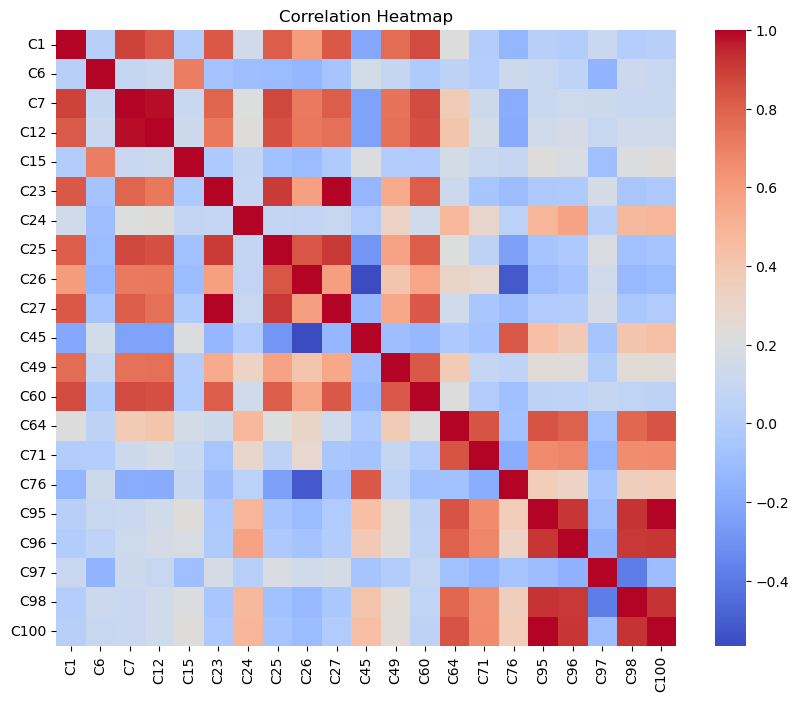

In [47]:
correlation_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

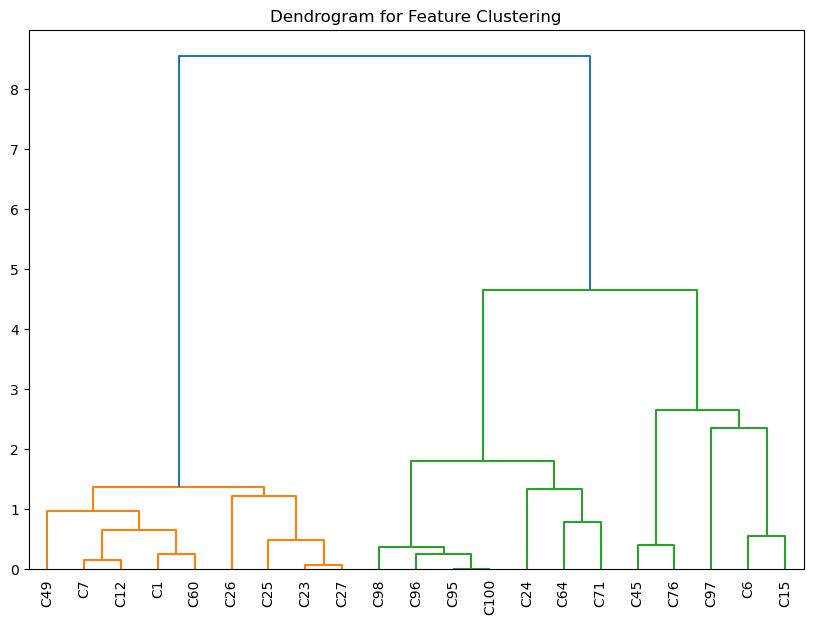

In [48]:
linkage_matrix = linkage(correlation_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=selected_features, leaf_rotation=90)
plt.title("Dendrogram for Feature Clustering")
plt.show()

## Feature selection

In [49]:
def cluster_and_select_representative_features(correlation_matrix, num_clusters):
    distance_matrix = 1 - np.abs(correlation_matrix)
    linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')
    
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    cluster_df = pd.DataFrame({
        "Feature": correlation_matrix.columns,
        "Cluster": clusters
    })
    
    representative_features = []
    for cluster_id in cluster_df["Cluster"].unique():
        cluster_features = cluster_df.loc[cluster_df["Cluster"] == cluster_id, "Feature"].values
        cluster_corr = correlation_matrix.loc[cluster_features, cluster_features].mean(axis=1)
        representative = cluster_corr.idxmax()
        representative_features.append(representative)
    
    return representative_features

In [50]:
representative_features = cluster_and_select_representative_features(
    correlation_matrix=correlation_matrix,
    num_clusters=7
)

# Classification methods

In [51]:
def train_and_evaluate_model(df, features, target_col, model, imprimir=False):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target_col], test_size=0.2, random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    
    return macro_f1

In [52]:
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    df=df,
    features=representative_features,
    target_col="tumor_type",
    model=rf_model,
    imprimir=True
)

Classification Report:
              precision    recall  f1-score   support

         HGG       0.89      0.97      0.93        58
         LGG       0.78      0.50      0.61        14

    accuracy                           0.88        72
   macro avg       0.83      0.73      0.77        72
weighted avg       0.87      0.88      0.86        72



# Optimization process

In [54]:
def optimize_and_evaluate(df, target_col="tumor_type", num_clusters_range=range(3, 11), models=None):
    if models is None:
        models = {
            "RandomForest": RandomForestClassifier(random_state=42),
            "GradientBoosting": GradientBoostingClassifier(random_state=42),
            "ExtraTrees": ExtraTreesClassifier(random_state=42),
            "DecisionTree": DecisionTreeClassifier(random_state=42),
            "LogisticRegression": LogisticRegression(random_state=42, max_iter=500),
            "SVM": SVC(random_state=42),
            "KNN": KNeighborsClassifier()
        }

    results = []

    df_features, selected_columns_after_variance = apply_variance_threshold(df, target_col, threshold=0.01)
    
    selected_features = apply_boruta(df_features, target_col, selected_columns_after_variance)
    
    selected_data = df[selected_features]
    correlation_matrix = selected_data.corr()
    
    for num_clusters in num_clusters_range:
        representative_features = cluster_and_select_representative_features(correlation_matrix, num_clusters)
        
        for model_name, model in models.items():
            macro_f1 = train_and_evaluate_model(df, representative_features, target_col, model)
            
            results.append({
                "Num_Clusters": num_clusters,
                "Model": model_name,
                "Macro_F1_Score": macro_f1
            })
    
    results_df = pd.DataFrame(results)
    return results_df

In [55]:
df_results = optimize_and_evaluate(df)

## Some analysis

In [75]:
def plot_f1_score_by_model(results_df):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=results_df, x="Model", y="Macro_F1_Score", ci=None, palette="viridis")
    plt.title("Macro F1-Score by Model", fontsize=16)
    plt.ylabel("Macro F1-Score", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

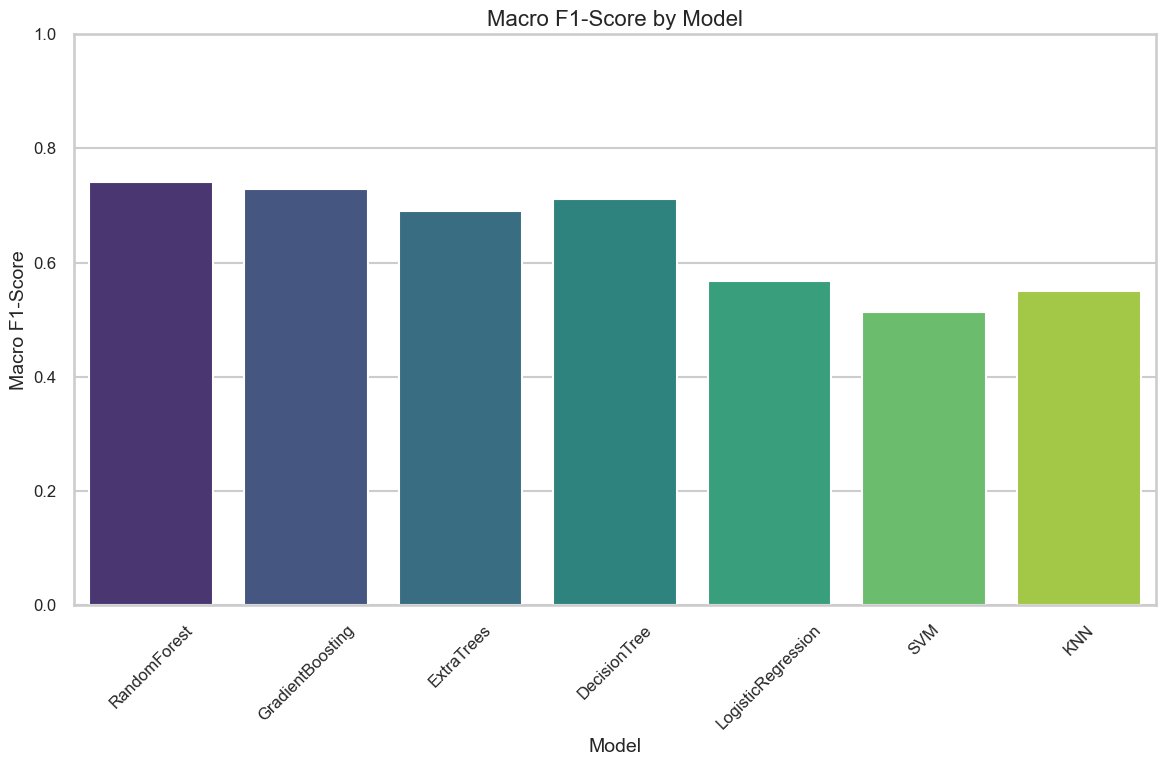

In [76]:
plot_f1_score_by_model(df_results)

In [81]:
def plot_f1_score_vs_clusters(results_df):
    plt.figure(figsize=(8, 6))
    mean_scores = results_df.groupby("Num_Clusters")["Macro_F1_Score"].mean().reset_index()
    sns.lineplot(data=mean_scores, x="Num_Clusters", y="Macro_F1_Score", marker="o", color="blue", linewidth=2)
    plt.title("Impact of Number of Clusters on Macro F1-Score", fontsize=16)
    plt.ylabel("Average Macro F1-Score", fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

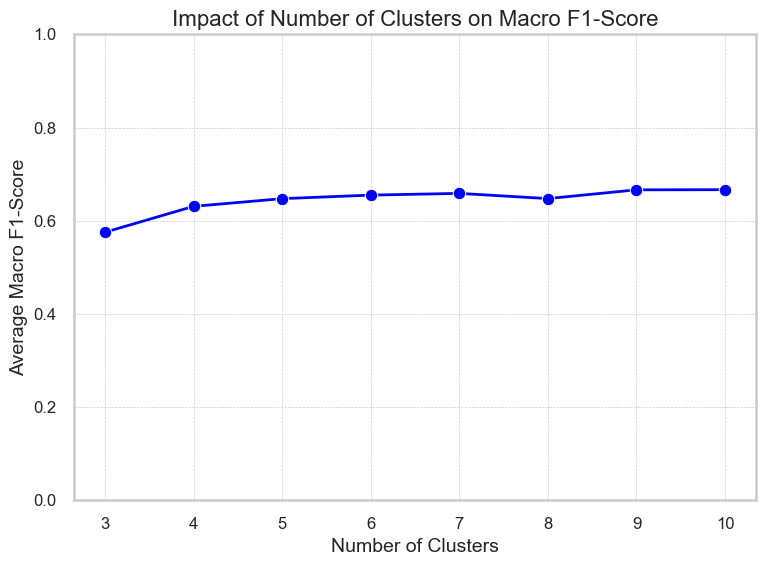

In [82]:
plot_f1_score_vs_clusters(df_results)

In [95]:
def plot_heatmap_model_vs_clusters(results_df):
    plt.figure(figsize=(14, 8))
    pivot_table = results_df.pivot(index="Num_Clusters", columns="Model", values="Macro_F1_Score")
    sns.heatmap(pivot_table, fmt=".2f", cmap="coolwarm", cbar=True, vmin=0, vmax=1, linewidths=0.5)
    plt.title("Macro F1-Score by Model and Number of Clusters", fontsize=16)
    plt.ylabel("Number of Clusters", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

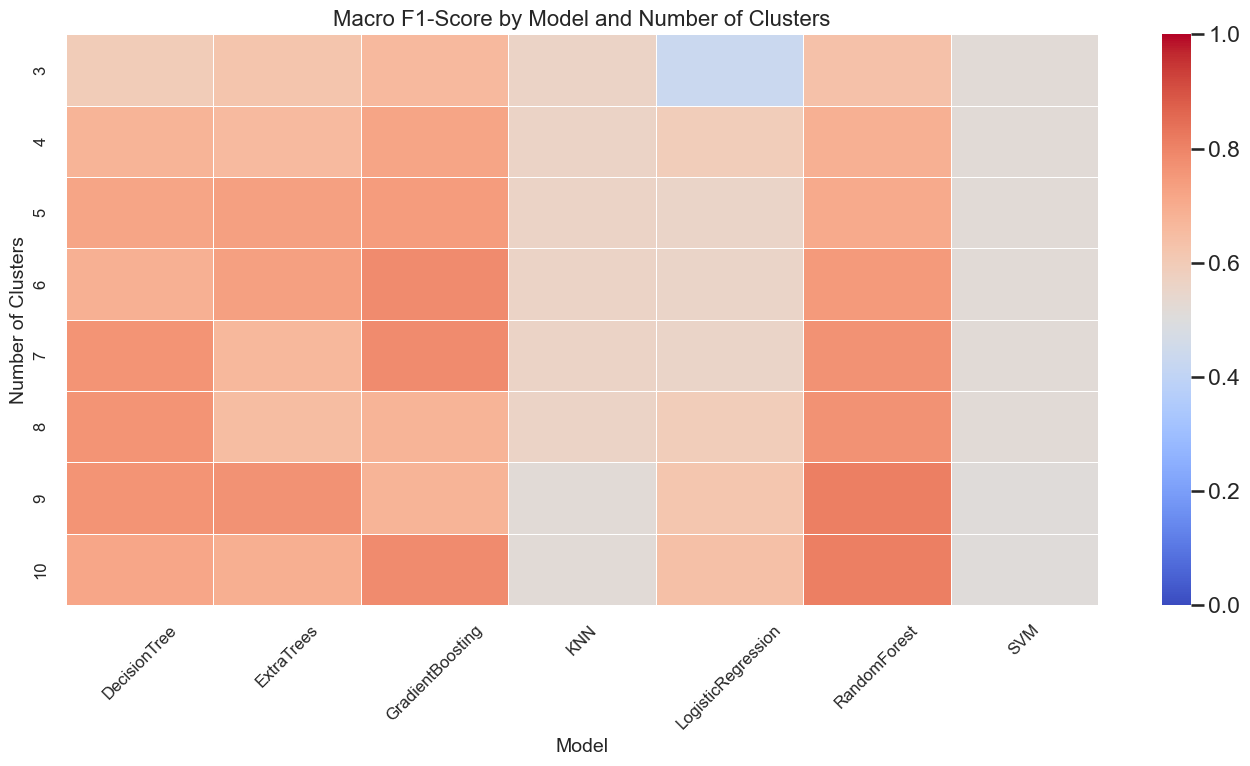

In [96]:
plot_heatmap_model_vs_clusters(df_results)

## Best model optimization

In [98]:
df_results.iloc[df_results['Macro_F1_Score'].idxmax()]

Num_Clusters                 9
Model             RandomForest
Macro_F1_Score        0.812256
Name: 42, dtype: object

In [105]:
def retrain_best_model(df_results = df_results, 
                       df = df, 
                       correlation_matrix = correlation_matrix, 
                       target_col="tumor_type", 
                       imprimir=True):
    
    best_model_row = df_results.iloc[df_results['Macro_F1_Score'].idxmax()]
    
    num_clusters = int(best_model_row['Num_Clusters'])
    model_name = best_model_row['Model']
    
    if model_name == "RandomForest":
        model = RandomForestClassifier(random_state=42)
    elif model_name == "DecisionTree":
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == "LogisticRegression":
        model = LogisticRegression(random_state=42, max_iter=500)
    elif model_name == "SVM":
        model = SVC(random_state=42)
    else:
        raise ValueError(f"Modelo no reconocido: {model_name}")
    
    representative_features = cluster_and_select_representative_features(
        correlation_matrix=correlation_matrix,
        num_clusters=num_clusters
    )
    
    macro_f1_score = train_and_evaluate_model(
        df=df,
        features=representative_features,
        target_col=target_col,
        model=model,
        imprimir=imprimir
    )

In [106]:
retrain_best_model()

Classification Report:
              precision    recall  f1-score   support

         HGG       0.92      0.95      0.93        58
         LGG       0.75      0.64      0.69        14

    accuracy                           0.89        72
   macro avg       0.83      0.80      0.81        72
weighted avg       0.88      0.89      0.89        72

